# Smoothed Opacities

In this notebook we will try smoothing single grain opacities over a small distribution of similar sized particles to avoid strong, unrealistic resonances.

Since linear averaging produces smoother results, we will use those as standard.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from disklab import opacity

plt.style.use([{'figure.dpi':100}])

Calculate the current default opacities

In [2]:
a = np.logspace(-5, 2, 200)
lam = np.logspace(np.log10(1e-5), 1, 210)

dc,rho_s = opacity.get_dsharp_mix()
result = opacity.get_opacities(a, lam, rho_s=rho_s, diel_const=dc, extrapolate_large_grains=True)

k_abs  = result['k_abs']
k_sca  = result['k_sca']
g      = result['g']
theta  = result['theta']
S1     = result['S1']
S2     = result['S2']
rho_s  = result['rho_s']

Reading opacities from troilitek
Reading opacities from organicsk
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |
Mie ... Done!


## Linear Averaging

Calculate the same but at a much higher resolution. We'll save it to save time in case we need to restat the kernel. We will make `n_inter-1` linear grid points in between every current grid point.

In [3]:
n_inter = 40

In [4]:
a_l = np.array([a[0]])
for i in range(len(a)-1):
    a_l = np.hstack((a_l, np.linspace(a[i], a[i+1], n_inter)[1:]))

# for now we will take the same wavelength grid

lam_l = lam.copy()

# lam_l = np.array([lam[0]])
#for i in range(len(lam)-1):
#    lam_l = np.hstack((lam_l, np.linspace(lam[i], lam[i+1], n_inter)[1:]))

result_l = opacity.get_opacities(a_l, lam_l, rho_s=rho_s, diel_const=dc, extrapolate_large_grains=True)

k_abs_l  = result_l['k_abs']
k_sca_l  = result_l['k_sca']
g_l      = result_l['g']
rho_s_l  = result_l['rho_s']

np.savez_compressed('highres_opacities_linear', a_l=a_l, lam_l=lam_l, k_abs_l=k_abs_l.T, k_sca_l=k_sca_l.T, g_l=g_l)

Mie ... Done!


This is how to load the opacities. **Note:** here we transpose back to the shape that comes out of the calculation. The format we save it in and that others use are transposed.

In [5]:
data = np.load('highres_opacities_linear.npz')

a_l = data['a_l']
lam_l = data['lam_l']
k_abs_l = data['k_abs_l'].T
k_sca_l = data['k_sca_l'].T
g_l = data['g_l']

Next, we want to average the opacity over a size distributions, in this case constant distribution. For the averaging, we will take the original grid points as centers and average `(n_inter+1)//2 - 1` to the left and right.

In [6]:
k_sca_avg_l = np.zeros_like(k_sca)
k_abs_avg_l = np.zeros_like(k_abs)
g_avg_l     = np.zeros_like(k_abs)

n_avg = (n_inter + 1) // 2 - 1

for i in range(len(a)):
    # find the corresponding index in high res
    ia_l = (n_inter-1) * i
    
    i0 = max(ia_l-n_avg, 0)
    i1 = min(ia_l+n_avg, len(a_l) - 1)
    
    k_abs_avg_l[i, :] = k_abs_l[i0:i1 + 1, :].sum(0) / (i1 - i0 + 1)
    k_sca_avg_l[i, :] = k_sca_l[i0:i1 + 1, :].sum(0) / (i1 - i0 + 1)
    g_avg_l[i, :]     =     g_l[i0:i1 + 1, :].sum(0) / (i1 - i0 + 1)

Save this one as a default opacity

In [7]:
np.savez_compressed('default_opacities_smooth', a=a, lam=lam_l, k_abs=k_abs_avg_l.T, k_sca=k_sca_avg_l.T, g=g_avg_l)

## Gaussian Averaging

In [8]:
n_inter = 40  # nr. of grid points around every original grid point, should be even
eps     = 0.1 # how far around each grid point the averaging-grid extends
sigma   = 0.05 # the width of the gaussian weights around a[i] (in terms of a[i])

In [9]:
# first grid point

a_left = a[0] * a[0] / a[1] # calculate a[-1] grid point
da = eps * (a[0] - a_left)

a_g = np.linspace(a[0] - da, a[0] + da, n_inter-1)

# other grid points

for i in range(1, len(a)):
    da = eps * (a[i] - a[i - 1])
    a_g = np.hstack((a_g, np.linspace(a[i] - da, a[i] + da, n_inter-1)))

In [10]:
# for now we will take the same wavelength grid

lam_g = lam.copy()

result_g = opacity.get_opacities(a_g, lam_g, rho_s=rho_s, diel_const=dc, extrapolate_large_grains=True)

k_abs_g  = result_g['k_abs']
k_sca_g  = result_g['k_sca']
g_g      = result_g['g']
rho_s_g  = result_g['rho_s']

np.savez_compressed('highres_opacities_gauss', a_g=a_g, lam_g=lam_g, k_abs_g=k_abs_g.T, k_sca_g=k_sca_g.T, g_g=g_g)

Mie ... Done!


In [11]:
data = np.load('highres_opacities_gauss.npz')

a_g = data['a_g']
lam_g = data['lam_g']
k_abs_g = data['k_abs_g'].T
k_sca_g = data['k_sca_g'].T
g_g = data['g_g']

Next, we want to average the opacity over a gaussian distribution. For the averaging, we will take the original grid points as centers and average `(n_inter+1)//2 - 1` to the left and right.

In [12]:
k_sca_avg_g = np.zeros_like(k_sca)
k_abs_avg_g = np.zeros_like(k_abs)

n_avg = (n_inter + 1) // 2 - 1

for i in range(len(a)):
    # find the corresponding index in high res
    ia_g = (n_inter-1) * i + n_inter//2 - 1
    
    i0 = max(ia_g-n_avg, 0)
    i1 = min(ia_g+n_avg, len(a_g) - 1)
    
    w = np.exp(-(a[i]-a_g[i0:i1+1])**2/(2*(sigma*a[i])**2))
    w /= w.sum()
    
    k_abs_avg_g[i, :] = (w[:, None] * k_abs_g[i0:i1 + 1, :]).sum(0)
    k_sca_avg_g[i, :] = (w[:, None] * k_sca_g[i0:i1 + 1, :]).sum(0)

Sanity check: find low- and highres-grid point and plot the weighting function

a  [i]    = 0.03292971255097151
a_g[ia_g] = 0.03292971255097151


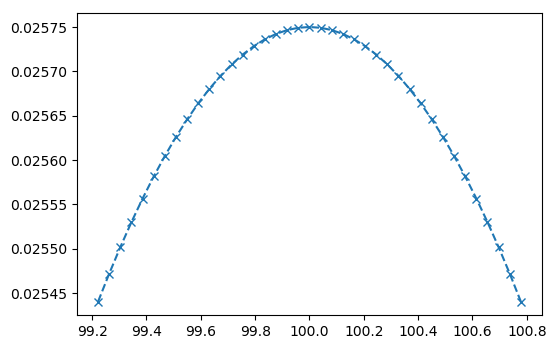

In [13]:
i = 100
ia_g = (n_inter-1) * i + n_inter//2 - 1
print(f'a  [i]    = {a[i]}')
print(f'a_g[ia_g] = {a_g[ia_g]}')

plt.plot(a_g[i0:i1+1],w,'--x')

## Plotting

Show the size averaged opacity and $\beta$ as function of $a_\mathrm{max}$.

kappa_abs @       1 mm for a_max = 1mm : 2.89 cm^2/g
kappa_abs @       3 mm for a_max = 1mm : 0.453 cm^2/g


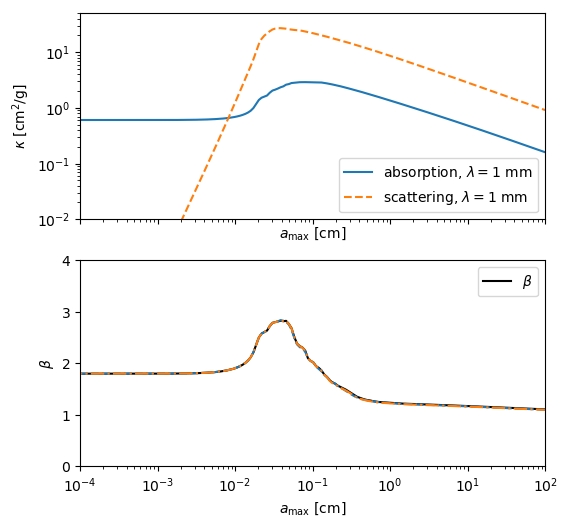

In [14]:
lam_avg =[0.1, 0.3]

f, axs = plt.subplots(2,1,sharex=True, figsize=(6,6))

r = opacity.size_average_opacity(lam_avg, a, lam, k_abs, k_sca, plot=True, ax=axs)
for i, _lam in enumerate(lam_avg):
    print('kappa_abs @ {:7.3g} mm for a_max = 1mm : {:.3g} cm^2/g'.format(_lam *10, np.interp(_lam, a, r['ka'][i])))

rl = opacity.size_average_opacity(lam_avg, a, lam, k_abs_avg_l, k_sca_avg_l, plot=False)
r['ax2'].semilogx(a, rl['beta'],'--')

rg = opacity.size_average_opacity(lam_avg, a, lam, k_abs_avg_g, k_sca_avg_g, plot=False)
r['ax2'].semilogx(a, rg['beta'],'-.')

Plot the opacities averaged over a typical size distribution to check if the results got smoother

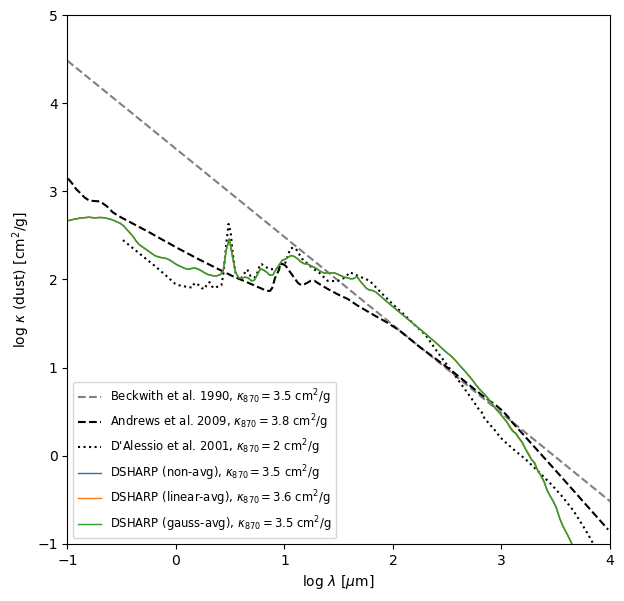

In [15]:
# a 1g-normalized size distribution (bin-integrated) up to 1 mm

s = a**0.5
s[a > 0.1] = 0
s= s / s.sum()

# size average the absorption opacities

ka0 = (k_abs * s[:,None]).sum(0)
kal = (k_abs_avg_l * s[:,None]).sum(0)
kag = (k_abs_avg_g * s[:,None]).sum(0)


# where to measure the reference value
lam_obs = 0.087

# load the D'Alessio opacity
d2g = sum([0.0056, 0.0034, 0.000768, 0.0041])
data_d01 = np.loadtxt('data/kappa_D01_T100K_p3.5_amax1mm.csv')
lam_d01 = 10.**data_d01[:,0] * 1e-4
kap_d01 = 10.**(data_d01[:,1]) / d2g

# the Beckwith 1990 law

kb = 3.5 * (lam / 0.087)**(-1)  # Beckwith 1990

# the opacities from Andrews et al. 2009

la, ka = np.loadtxt('data/andrews2009.dat').T

# now the plot

f, ax = plt.subplots(figsize=(7,7))

ax.plot(np.log10(1e4*lam),     np.log10(kb),      'k--', zorder=-100, alpha=0.5, label='Beckwith et al. 1990, $\kappa_{{{:.0f}}} = {:3.2g}$ cm$^2$/g'.format(     lam_obs*1e4, np.interp(lam_obs,lam,kb)))
ax.plot(np.log10(la),          np.log10(ka),      'k--', zorder=-100, alpha=1.0, label='Andrews et al. 2009, $\kappa_{{{:.0f}}} = {:3.2g}$ cm$^2$/g'.format(      lam_obs*1e4, np.interp(lam_obs*1e4,la,ka)))
ax.plot(np.log10(1e4*lam_d01), np.log10(kap_d01), 'k:',  zorder=-100, alpha=1.0, label='D\'Alessio et al. 2001, $\kappa_{{{:.0f}}} = {:3.2g}$ cm$^2$/g'.format(   lam_obs*1e4, np.interp(lam_obs,lam_d01,kap_d01)))
ax.plot(np.log10(1e4*lam),     np.log10(ka0),            zorder=-100, lw=1, alpha=1.0, label='DSHARP (non-avg), $\kappa_{{{:.0f}}} = {:3.2g}$ cm$^2$/g'.format(         lam_obs*1e4, np.interp(lam_obs,lam,ka0)))
ax.plot(np.log10(1e4*lam),     np.log10(kal),            zorder=-100, lw=1, alpha=1.0, label='DSHARP (linear-avg), $\kappa_{{{:.0f}}} = {:3.2g}$ cm$^2$/g'.format(      lam_obs*1e4, np.interp(lam_obs,lam,kal)))
ax.plot(np.log10(1e4*lam),     np.log10(kag),            zorder=-100, lw=1, alpha=1.0, label='DSHARP (gauss-avg), $\kappa_{{{:.0f}}} = {:3.2g}$ cm$^2$/g'.format(       lam_obs*1e4, np.interp(lam_obs,lam,kag)))

ax.legend(loc=3, fontsize='small')
ax.set_xlim(-1,4)
ax.set_ylim(-1,5)
ax.set_xlabel('log $\lambda$ [$\mu$m]')
ax.set_ylabel('log $\kappa$ (dust) [cm$^2$/g]')
plt.savefig('avgs.pdf')

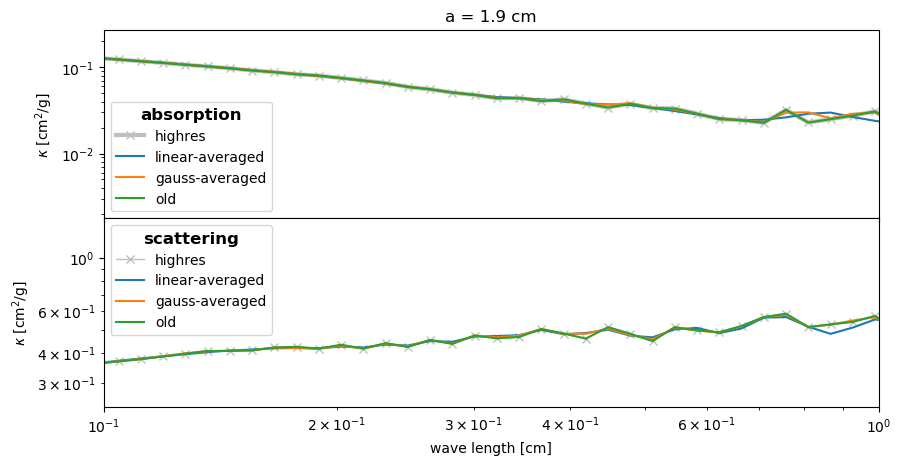

In [16]:
ia = 150
ia_l = (n_inter-1) * ia

f, axs = plt.subplots(2,1, figsize=(10,5), sharex=True)

axs[0].loglog(lam_l, k_abs_l[ia_l,:], marker='x', c='0.75', lw=3, label='highres')
axs[0].loglog(lam, k_abs_avg_l[ia,:], label='linear-averaged')
axs[0].loglog(lam, k_abs_avg_g[ia,:], label='gauss-averaged')
axs[0].loglog(lam, k_abs[ia, :], '-', label='old')
axs[0].legend().set_title('absorption', {'size':'large', 'weight':'bold'})

axs[1].loglog(lam_l, k_sca_l[ia_l,:], marker='x', c='0.75', lw=1, label='highres')
axs[1].loglog(lam, k_sca_avg_l[ia,:], label='linear-averaged')
axs[1].loglog(lam, k_sca_avg_g[ia,:], label='gauss-averaged')
axs[1].loglog(lam, k_sca[ia, :], '-', label='old')
axs[1].legend().set_title('scattering', {'size':'large', 'weight':'bold'})


axs[0].set_title('a = {:2.2g} cm'.format(a[ia]))

f.subplots_adjust(hspace=0)

ax.set_xscale('linear')
ax.set_yscale('linear')

axs[0].set_xlim(1e-1, 1e0);

for ax in axs:
    axs[1].set_xlabel('wave length [cm]')
    ax.set_ylabel('$\kappa$ [cm$^2$/g]')

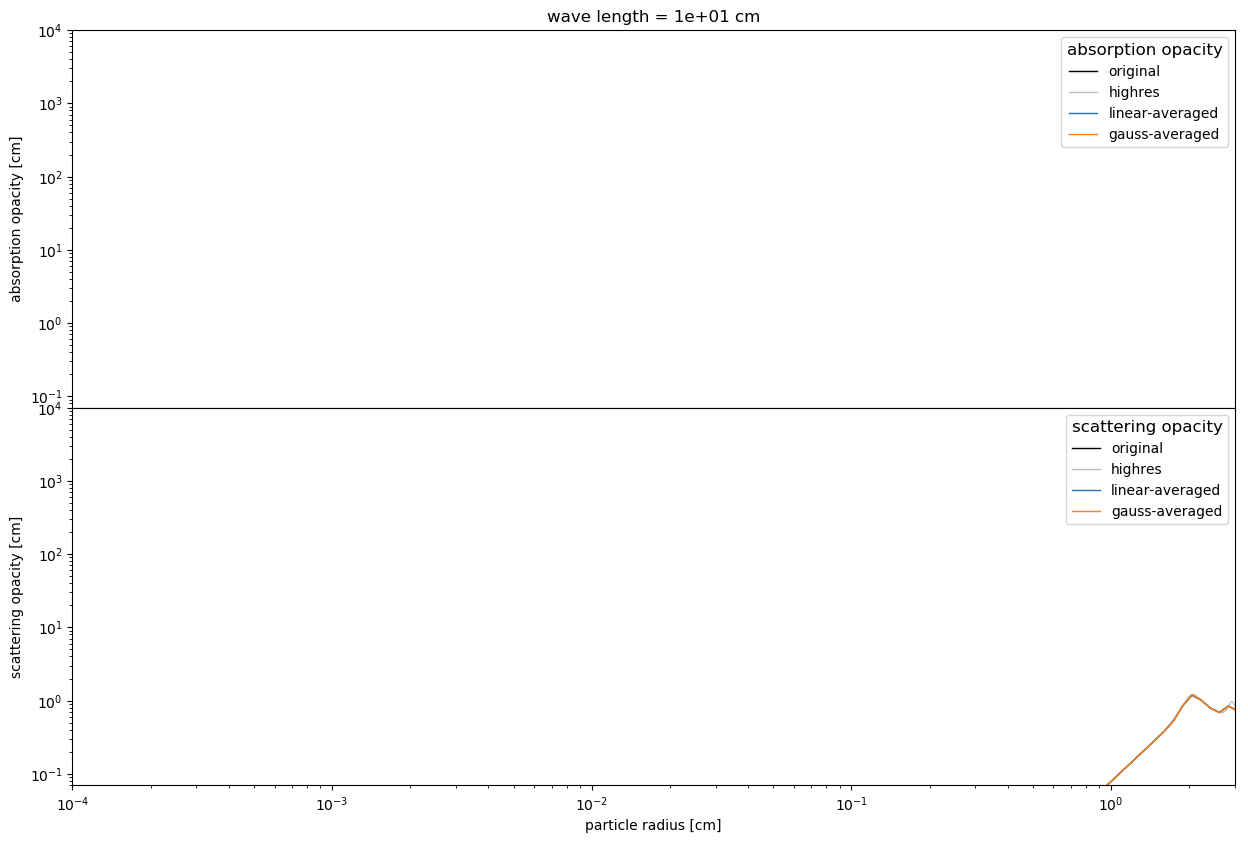

In [17]:
import os
if not os.path.isdir('imgs'): os.mkdir('imgs')
with plt.rc_context(rc={'lines.linewidth': 1}):
    f, axs = plt.subplots(2, 1, figsize=(15,10), sharex=True)
    
    for ilam in range(len(lam)): #[0,199]:
        if ilam==0:
            l01, = axs[0].loglog(a, k_abs[:, ilam], 'k', label='original')
            l02, = axs[0].loglog(a_l, k_abs_l[:, ilam],'-', lw=1, c='0.75', label='highres')
            l03, = axs[0].loglog(a, k_abs_avg_l[:, ilam], label='linear-averaged')
            l04, = axs[0].loglog(a, k_abs_avg_g[:, ilam], label='gauss-averaged')
            leg=axs[0].legend()
            leg.set_title('absorption opacity', {'size':'large'})

            l11, = axs[1].loglog(a, k_sca[:, ilam], 'k', label='original')
            l12, = axs[1].loglog(a_l, k_sca_l[:, ilam],'-', lw=1, c='0.75', label='highres')
            l13, = axs[1].loglog(a, k_sca_avg_l[:, ilam], label='linear-averaged')
            l14, = axs[1].loglog(a, k_sca_avg_g[:, ilam], label='gauss-averaged')
            leg = axs[1].legend()
            leg.set_title('scattering opacity', {'size':'large'})

            for ax in axs:
                ax.set_xlim(1e-4,3e0)
                ax.set_ylim(ymin=7e-2, ymax=1e4)
                ax.set_xlabel('particle radius [cm]')

            axs[0].set_ylabel('absorption opacity [cm]')
            axs[1].set_ylabel('scattering opacity [cm]')
            ti = axs[0].set_title(f'wave length = {lam[ilam]:3.2} cm')
            f.subplots_adjust(hspace=0)
        else:
            l01.set_ydata(k_abs[:, ilam])
            l02.set_ydata(k_abs_l[:, ilam])
            l03.set_ydata(k_abs_avg_l[:, ilam])
            l04.set_ydata(k_abs_avg_g[:, ilam])
            
            l11.set_ydata(k_sca[:, ilam])
            l12.set_ydata(k_sca_l[:, ilam])
            l13.set_ydata(k_sca_avg_l[:, ilam])
            l14.set_ydata(k_sca_avg_g[:, ilam])
            
            ti.set_text(f'wave length = {lam[ilam]:3.2} cm')
        f.savefig(f'imgs/img_{ilam:03d}.png',dpi=200)

In [18]:
!ffmpeg -r 60 -f image2 -i imgs/img_%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p movie01.mp4

ffmpeg version 3.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 9.0.0 (clang-900.0.37)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.4 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      55. 78.100 / 55. 78.100
  libavcodec     57.107.100 / 57.107.100
  libavformat    57. 83.100 / 57. 83.100
  libavdevice    57. 10.100 / 57. 10.100
  libavfilter     6.107.100 /  6.107.100
  libavresample   3.  7.  0 /  3.  7.  0
  libswscale      4.  8.100 /  4.  8.100
  libswresample   2.  9.100 /  2.  9.100
  libpostproc    54.  7.100 / 54.  7.100
Input #0, image2, from 'imgs/img_%03d.png':
  Duration: 00:00:03.50, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 3000x2000 [SAR 7874:7874 DAR 3:2], 60 fps, 60 tbr, 60 tbn,